In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

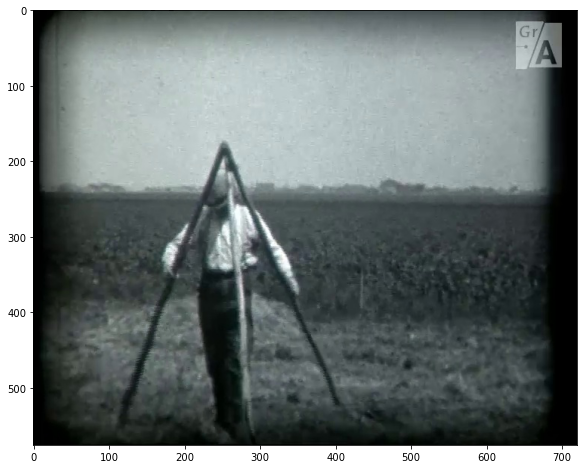

In [2]:
# Loading example image 

#img = plt.imread("frames/AV2171/keyframe_1867.0.jpg")
img = plt.imread("frames/AV0843/keyframe_9145.0.jpg")
#img = plt.imread("frames/contemporary/IMG_2864.jpeg")
#img = plt.imread("frames/AV0539/keyframe_2966.0.jpg")
#img = cv2.imread("/Users/blazejmanczak/Desktop/sudoku.jpg")
plt.figure(figsize = (10,8))
plt.imshow(img, cmap = "gray")

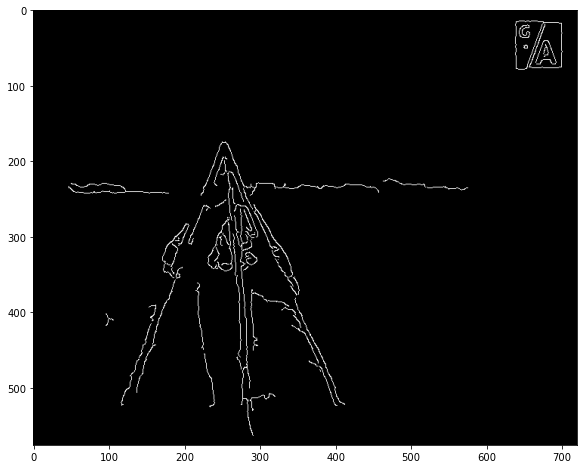

In [3]:
#gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
blurred_image = cv2.GaussianBlur(img, (7, 7), 0) # filter out week lines
edges_image = cv2.Canny(blurred_image, 50, 120, apertureSize = 3) # 120 is another visually optimal value 
plt.figure(figsize = (10,8))
plt.imshow(edges_image, cmap = "gray")

### Non-probabailist Hough transform 
Some code snippets from: https://medium.com/@tomasz.kacmajor/hough-lines-transform-explained-645feda072ab


In [4]:
def draw_lines(img, houghLines, color=[0, 255, 0], thickness=2):
    for line in houghLines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
 
            cv2.line(img,(x1,y1),(x2,y2),color,thickness)   
                
 
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

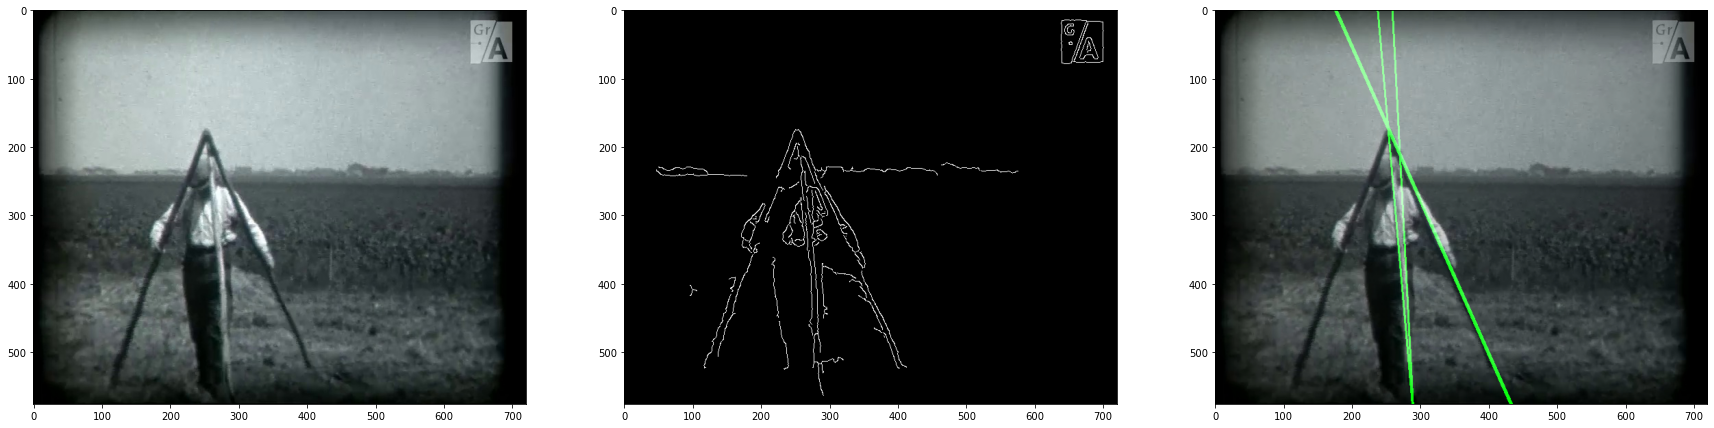

In [5]:
rho_resolution = 1
theta_resolution = np.pi/180
threshold = 100 #Only lines that are greater than threshold will be returned.
 
hough_lines = cv2.HoughLines(edges_image, rho_resolution , theta_resolution , threshold)
 
hough_lines_image = np.zeros_like(img)
draw_lines(hough_lines_image, hough_lines)
original_image_with_hough_lines = weighted_img(hough_lines_image,img)
 
plt.figure(figsize = (30,20))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(edges_image, cmap='gray')
plt.subplot(133)
plt.imshow(original_image_with_hough_lines, cmap='gray') 

### Probabilistic Hough transform 
This tutorial has been useful: https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html, especially for interpretting the function parameters

1 0.017453292519943295 100 150 30
6


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f88522d8730>)

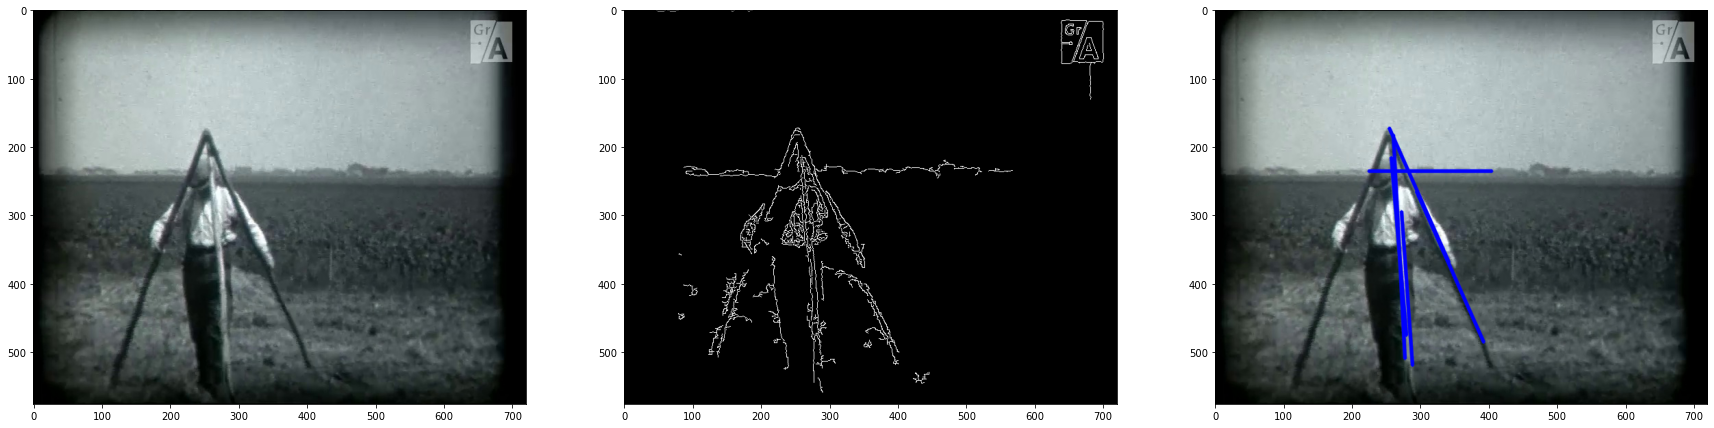

In [6]:
threshold = 100 # The minimum number of intersections in hough space to "detect" a line. higher -> less lines
minLineLength = 150 # The minimum number of points that can form a line. Lines with less than this number of points are disregarded. higher -> less lines
maxLineGap = 30 # The maximum gap between two points to be considered in the same line. higher -> more lines

#threshold = 200 # The minimum number of intersections in hough space to "detect" a line. higher -> less lines
#minLineLength = 150 # The minimum number of points that can form a line. Lines with less than this number of points are disregarded. higher -> less lines
#maxLineGap = 25 # The maximum gap between two points to be considered in the same line. higher -> more lines


edges_image = cv2.Canny(img, 50, 200,None, apertureSize = 3)  # without Blur
hough_lines_p = cv2.HoughLinesP(edges_image,1, np.pi / 180, threshold, None, minLineLength, maxLineGap)
print(1, np.pi/180, threshold, minLineLength, maxLineGap)
print(len(hough_lines_p))

original_image_with_hough_lines = img.copy()

for i in range(0, len(hough_lines_p)):
        l = hough_lines_p[i][0]
        cv2.line(original_image_with_hough_lines, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

#original_image_with_hough_lines = weighted_img(hough_lines_p_image,img)
    
plt.figure(figsize = (30,20))
plt.subplot(131), plt.imshow(img)
plt.subplot(132), plt.imshow(edges_image, cmap='gray')
plt.subplot(133), plt.imshow(original_image_with_hough_lines, cmap='gray') 

## Wrapping the transformations into a function

In [7]:
# Set the parameters

rho_resolution = 1
theta_resolution = np.pi/180
threshold = 100 # The minimum number of intersections in hough space to "detect" a line. higher -> less lines

# Additional parameters for probabilistic
minLineLength = 150 # The minimum number of points that can form a line. Lines with less than this number of points are disregarded. higher -> less lines
maxLineGap = 30 # The maximum gap between two points to be considered in the same line. higher -> more lines


def apply_hough(img, threshold = threshold, minLineLength = minLineLength, maxLineGap = maxLineGap, probabilistic = True):
    """Applies the Hough transform""" 
    
    if probabilistic:
        blurred_image = cv2.GaussianBlur(img, (5, 5), 0) # filter out week lines
        edges_image = cv2.Canny(blurred_image, 50, 120,None, apertureSize = 3)  #  applying Canny on the blurred image
        hough_lines = cv2.HoughLinesP(edges_image,rho_resolution, theta_resolution, threshold, None, minLineLength, maxLineGap)
        
    else:
        blurred_image = cv2.GaussianBlur(img, (7, 7), 0) # filter out week lines
        edgs_image = cv2.Canny(blurred_image, 50, 150, apertureSize = 3) # 120 is another visually optimal value 
        hough_lines = cv2.HoughLines(edges_image, rho_resolution , theta_resolution , threshold)
     
    return hough_lines

def get_angle(hough_lines, radians = False):
    if radians:
        return np.arctan2(hough_lines[:, :,3] - hough_lines[:, :,1], hough_lines[:, :,2] - hough_lines[:, :,0])
    else: 
        return np.arctan2(hough_lines[:, :,3] - hough_lines[:, :,1], hough_lines[:, :,2] - hough_lines[:, :,0]) * 180/np.pi # better for numerical stability
    

def plot_lines(img, hough_lines, probabilistic = True):
    """Plots only probabilistic """

    original_image_with_hough_lines = img.copy()
    cmap = "gray" if img.shape[-1] == 3 else None 
        
    if probabilistic:
        for i in range(0, len(hough_lines)):
            l = hough_lines[i][0]
            cv2.line(original_image_with_hough_lines, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
            #break
    
    else:
        hough_lines_image = np.zeros_like(img)
        draw_lines(hough_lines_image, hough_lines)
        original_image_with_hough_lines = weighted_img(hough_lines_image,img)
    
    plt.figure(figsize = (15,10))
    plt.subplot(121), plt.imshow(img)
    plt.subplot(122), plt.imshow(original_image_with_hough_lines, cmap=cmap) 
    

"""
# Example usage
probabilistic = True

#img = plt.imread("frames/contemporary/IMG_2864.jpeg")
hough_lines = apply_hough(img, probabilistic = probabilistic)
plot_lines(img, hough_lines, probabilistic = probabilistic)
"""


'\n# Example usage\nprobabilistic = True\n\n#img = plt.imread("frames/contemporary/IMG_2864.jpeg")\nhough_lines = apply_hough(img, probabilistic = probabilistic)\nplot_lines(img, hough_lines, probabilistic = probabilistic)\n'

## Obtaining lines from the archive


In [8]:
#img_directory = "frames/AV0539"
img_directory = ['AV4508', 'AV0539', 'AV5361', 'AV0843', 'AV2171']
img_paths = []
temp_list = []
for directory in img_directory:
    temp_list += list(os.listdir(os.path.join("frames",directory)))
    
    for path in temp_list:
        img_paths.append(os.path.join("frames", directory, path))
        
    temp_list = []
    

img_paths = list(sorted(img_paths))

img_paths = np.random.choice(img_paths, size = int(0.5*len(img_paths)), replace = False) # take a random sample of 10$ of one directory
img_paths = img_paths.astype(str)

#imgs = np.array([cv2.imread(os.path.join(img_directory, path)) for path in img_paths])
#flat_imgs = imgs.reshape(imgs.shape[0], imgs.shape[1]*imgs.shape[2]*imgs.shape[3]) # used to calculate correlation using np.corrcoef 

The class *matchingObjects* allows us to store and perform transformation on an image in a simpler form than just using functions 

In [9]:
class matchingObjects:
    """
    Stores frequently accessed information about the images and contains methods useful for line fitting.
    
    Attributes:
    --------------------
    path: str
        if file is read from directory, path stores that directory
    img: np.array
        stores the image in the RGB fashion
    margin: int
        defines how much the borders should be clipped. Useful for old images that have black borders resulting in fake line detections
    shape: np.array
        stores shape of the image
    scale: float
        the scaling factor compared to the original image
    lines: np.array
        strores the x_start,y_start, x_end, y_end corrdinates of the line in the image with a given scale and margin (not the orignal image)
    angle: np.array
        stores the angle of the detcted lines corresponding to the lines at the same index as in the "lines" atrribute
    slope: np.array
        stores the slope of the detcted lines corresponding to the lines at the same index as in the "lines" atrribute
    length:
        stores the length of the detcted lines corresponding to the lines at the same index as in the "lines" atrribute
        
    
    
    Methods:
    -------------------
    
    hough_lines(self, probabilistic = True, radians = False, **kwargs):
        Applies probabilistic or non-probabilisitc hough transform and calculates the characteristics of found lines
    
    rank_and_pick_lines(self, delta_angle = 1, max_lines = None):
        Filters out lines having similiar angles (taking the longest line out of the "similiar ones") to later limit the dimensionality of the database of lines.
    
    """
    
    def __init__(self, path = None, margin = 50, img = None, scale = 1):
        """
        Parameters:
        -----------------
        path: str
            if file is read from directory, path stores that directory. If supplied, img is expected to be none.
        margin: int
            defines how much the borders should be clipped. Useful for old images that have black borders resulting in fake line detections. 
            Remeber to adjust your margin with scale!
        scale: float
            the scaling factor compared to the original image
        img: np.array
            stores the image in the RGB fashion. If supplied, path is expected to be none.
        """
        self.scale = scale
        if img is None: # read in the image from path
            
            self.path = path 

            if margin > 0: # deals with black borders that result in many fake line detections
                self.img = plt.imread(self.path)[margin:-margin, margin:-margin]
            else:
                self.img = plt.imread(self.path)
        

        elif path is None: # np array image is provided
            self.path = None
            if margin > 0: # deals with black borders that result in many fake line detections
                self.img = img[margin:-margin, margin:-margin]
            else:
                self.img = img   
        
        self.shape = self.img.shape
        
        if scale != 1:
            self.img = cv2.resize(self.img, (int(self.shape[0] * self.scale), int(self.shape[1] * self.scale)))
            self.shape = self.img.shape
       
    
    def hough_lines(self, probabilistic = True, radians = False, **kwargs):
        
        """
        Applies  probabilistic or non-probabilistic hough transform to find lines. Additionally, for each line, it determines the angle, slope and length.
        
        Parameters:
        -----------------
        probabilistic: bool
            Determings whether probabilistic or non-probabilistic hough transform is applied
        radians: bool
            Determines whether to use radians. False is preffered due to possible numerical underflow problems later.
        **kwargs: optional
            Additional arguments specyfing the parameters of the hough transform. Useful as the default has been optimized for archival, medium resolution photos
        
        """
        self.lines = apply_hough(self.img, probabilistic= probabilistic, **kwargs)

        if self.lines is not None: # if hough found something
            self.angle = get_angle(self.lines, radians = radians) # radians more stable
            
            x_diff = self.lines[:, :,2] - self.lines[:, :,0]# if 0 then slope will be -inf -> vertical line
            y_diff = self.lines[:, :,3] - self.lines[:, :,1] 
            self.slope = y_diff/x_diff
            self.length = np.sqrt(x_diff**2 + y_diff**2)
    
    def rank_and_pick_lines(self, delta_angle = 1, max_lines = None):
        """
        Filters out lines having similiar angles (taking the longest line out of the "similiar ones") to later limit the dimensionality of the database of lines.
        
        Parameters:
        -----------------
        delta_angle: float
            defines how close the angles have to be considered 'similiar' in terms of the angle
        max_lines:int
            specifiecs how many lines should be kept after filtering. The longest max_lines number of lines are kept.
        """

        initial_max = np.max(self.length)
        if self.lines is not None:
            lst0 = self.lines
            order = np.arange(0, len(lst0)).reshape(-1,1)
            lst1 = self.angle
            lst2 = self.length
            merged = np.concatenate([lst1, lst2, order], axis = 1)
            new_order = np.lexsort((lst2, lst1), axis = 0) # sorts first by angle then by length
            merged_new = merged[new_order]  #
            
            
            mask = ( np.diff(merged[new_order], axis = 0)[:,:,0] < delta_angle ) # boolean mask indicating whether the sorted values are withing delta_angle of each other
            series = False 
            
            for i in range(len(mask)): # marks 
                if mask[i] == True:
                    series = True
                elif (mask[i] == False) and (series == True):
                    mask[i] = True # make up for the offset in the mask
                    series = False # break the series
                    
            
            grouping_mask = np.concatenate((mask, np.array([[False]])) ) # adding the dimension lost by np.diff
            accum = [] #stores the longest line from found clusters 
            temp = [] # empty list for booking within clusters of similiar lines


            for i in range(len(grouping_mask)):  
                if grouping_mask[i] == False:
                    if (len(temp)>0): 
                        accum.append(np.array(temp)[np.argmax(np.array(temp), axis = 0)[0][1]])
                        temp = []
                    accum.append(merged_new[i,:,:])


                else: #if grouping_mask[i] == True:
                    if len(temp) > 0:
                        if abs(merged_new[i,:,:][0][0] - temp[-1][0][0]) < delta_angle: 
                            temp.append(merged_new[i,:,:])
                        else: 
                            
                            accum.append(np.array(temp)[np.argmax(np.array(temp), axis = 0)[0][1]])
                            temp = []
                            temp.append(merged_new[i,:,:])
                    else:

                        temp.append(merged_new[i,:,:])
            
            accum = np.array(accum)
            accum = accum[np.argsort(accum[:,:,1], axis = 0)] # sort by length
            if max_lines is not None: # if the maximum number of lines to be returned is specifed, pick the longest max_lines lines
                accum = accum[-max_lines:]
            cleaned_order = list(accum[:,:,:,2].flatten().astype(int))
            
            #Update the attribute values
            self.lines = self.lines[cleaned_order]
            self.angle = self.angle[cleaned_order]
            self.length = self.length[cleaned_order]
            self.slope = self.slope[cleaned_order]
            final_max = np.max(self.length)
        
            assert (abs(final_max - initial_max) < 0.01) # making sure the line of max length is preserved
            
        
        def plot_matches(self, matches, buffer = 5):
            self.matched_img = np.copy(self.img)
            pass
                
def get_non_zero_objects(obj_list):
    """
    Filters out images where no lines were found.
    
    Parametrs:
    ------------------
    obj_list: list
        List of elements of class matchingObjects
    
    """
    new_obj_list = []
    count_lines = 0
    for obj in obj_list:
        if obj.lines is not None:
            new_obj_list.append(obj)
            count_lines += len(obj.lines)
            
            
    print("{}% of input list contain lines".format(round(len(new_obj_list)/len(obj_list) * 100), 2))
    print("Given that the img contains a line, on average there are {} detected lines per image".format( round( count_lines/len(new_obj_list), 2 ) ))
    return new_obj_list
        

In [10]:
import time

start = time.time()

img_objects = np.array([matchingObjects(path, scale = 0.5) for path in img_paths])

# Apply hough transform to all objects in the array above
for obj in img_objects:
    obj.hough_lines()
    
non_zero_objects = get_non_zero_objects(img_objects)

print("Running hough lines for {} imgages took {} seconds.".format(len(img_paths), round(time.time() - start, 2)))

<ipython-input-9-2f908eb5f73c>:100: RuntimeWarning: divide by zero encountered in true_divide
  self.slope = y_diff/x_diff


47% of input list contain lines
Given that the img contains a line, on average there are 3.35 detected lines per image
Running hough lines for 1665 imgages took 21.59 seconds.


### Showacse of the line filtering method
Plots before and after applying the filtering of the lines

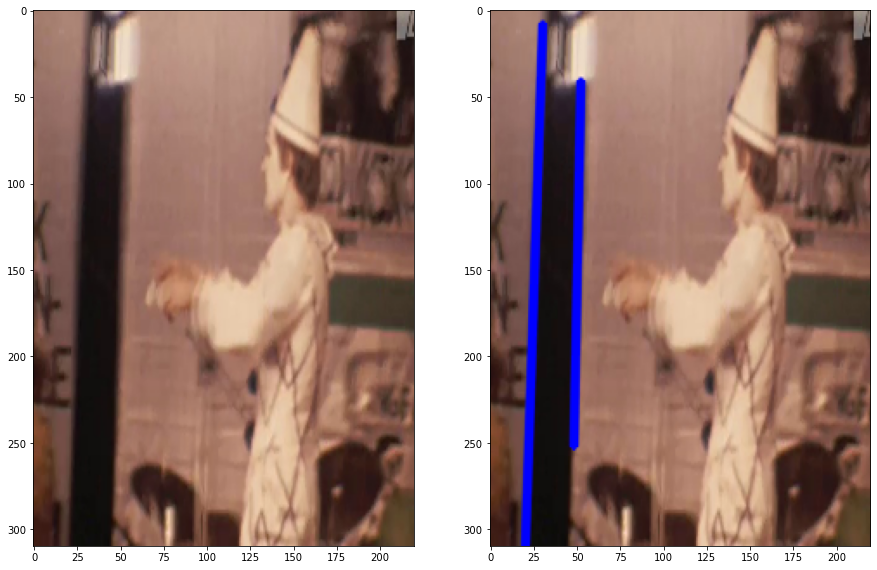

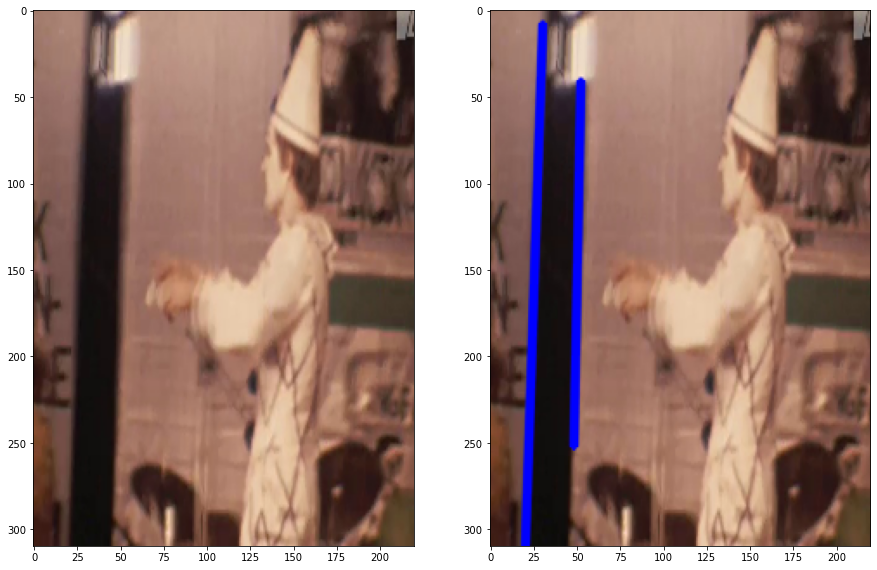

In [11]:
sample_number = 281 # 3
plot_lines(non_zero_objects[sample_number].img, non_zero_objects[sample_number].lines)
non_zero_objects[sample_number].rank_and_pick_lines(delta_angle=3, max_lines=3)
plot_lines(non_zero_objects[sample_number].img, non_zero_objects[sample_number].lines)

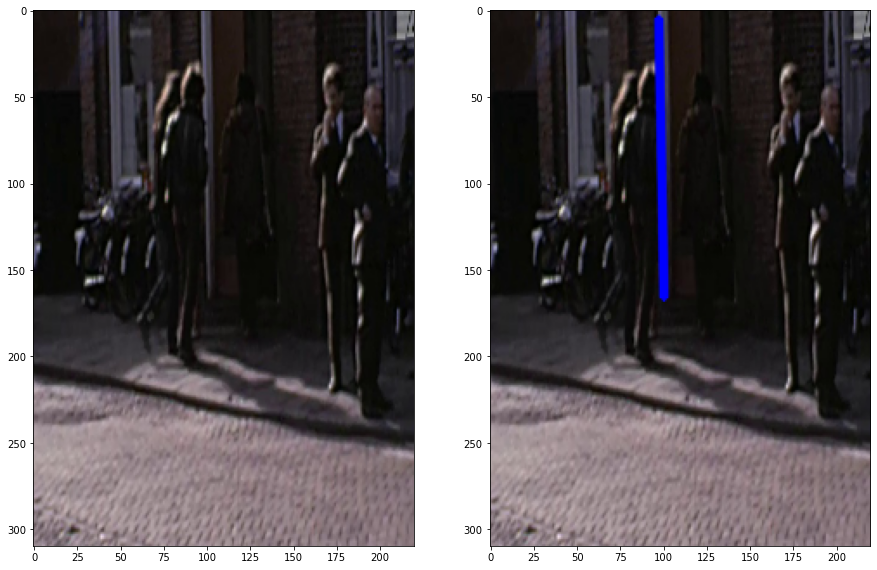

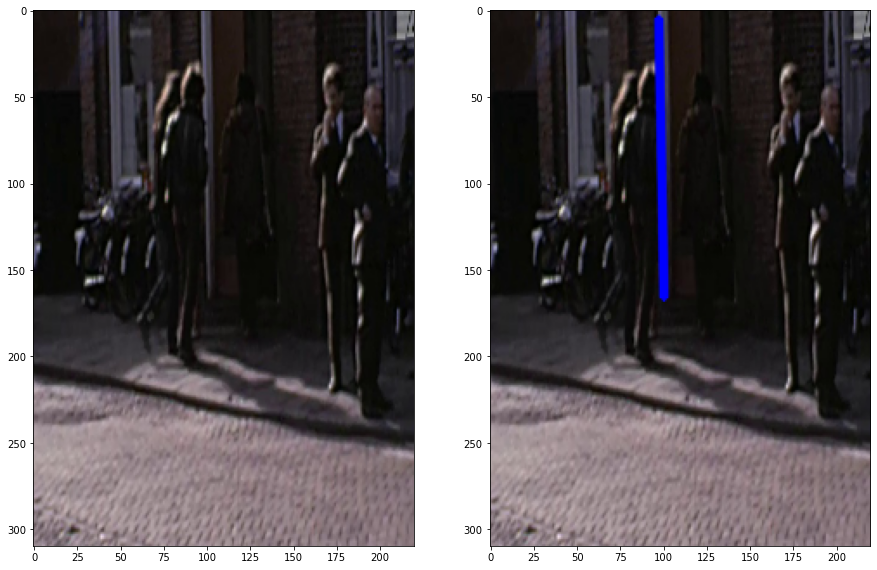

In [12]:
sample_number = 14 # 3
plot_lines(non_zero_objects[sample_number].img, non_zero_objects[sample_number].lines)
non_zero_objects[sample_number].rank_and_pick_lines(delta_angle=3, max_lines=None)
plot_lines(non_zero_objects[sample_number].img, non_zero_objects[sample_number].lines)

In [279]:
img = plt.imread("frames/contemporary/IMG_2864.jpeg")
#img = plt.imread("frames/AV0539/keyframe_2966.0.jpg")
#img = cv2.imread("/Users/blazejmanczak/Desktop/sudoku.jpg")
obj = matchingObjects(img = img, margin = 0)
obj.hough_lines()

<ipython-input-254-b313bb471255>:40: RuntimeWarning: divide by zero encountered in true_divide
  self.slope = y_diff/x_diff


In [281]:
"""
lst0 = non_zero_objects[17].lines
order = np.arange(0, len(lst0)).reshape(-1,1)
lst1 = non_zero_objects[17].angle
lst2 = non_zero_objects[17].length

print(len(lst0), len(lst1), len(lst2))
merged = np.concatenate([lst1, lst2, order], axis = 1)

"""

lst0 = obj.lines
order = np.arange(0, len(lst0)).reshape(-1,1)
lst1 = obj.angle
lst2 = obj.length

print(len(lst0), len(lst1), len(lst2))
merged = np.concatenate([lst1, lst2, order], axis = 1)

59 59 59


In [282]:
new_order = np.lexsort((lst2, lst1), axis = 0)
delta_angle = 3
merged_new = merged[new_order]
#merged_new

array([[[-90.        , 170.        ,  10.        ]],

       [[ -4.17856897, 219.58369703,  44.        ]],

       [[ -0.95484125, 180.02499826,  19.        ]],

       [[  1.86094107, 277.14617082,   5.        ]],

       [[  1.8911547 , 212.11553456,  29.        ]],

       [[  2.23947594, 179.13681922,  40.        ]],

       [[  2.90705418, 256.3298656 ,  26.        ]],

       [[  3.85680099, 267.60605374,  32.        ]],

       [[  3.95564548, 376.89786415,  18.        ]],

       [[  4.08561678, 196.49936387,  57.        ]],

       [[  4.11222884, 153.39491517,  47.        ]],

       [[  4.67416371, 159.53056134,  49.        ]],

       [[  4.86833237, 318.14776441,  17.        ]],

       [[  4.88520257, 234.8531456 ,  58.        ]],

       [[  4.95325748, 150.56227947,  54.        ]],

       [[  4.95325748, 301.12455895,  35.        ]],

       [[  4.96974073, 323.21509866,  41.        ]],

       [[  6.15184338, 167.96725871,  56.        ]],

       [[  8.90171603, 336.0

In [283]:
mask = ( np.diff(merged[new_order], axis = 0)[:,:,0] < delta_angle )  #( np.diff(merged[new_order], axis = 0)[:,:,1]  >0  )

In [284]:
series = False

for i in range(len(mask)):
    if mask[i] == True:
        series = True
    if (mask[i] == False) and (series == True):
        #print("here", mask[i])
        mask[i] = True
        series = False
        

In [285]:
merged_new[grouping_mask]

array([[ -0.95484125, 180.02499826,  19.        ],
       [  1.86094107, 277.14617082,   5.        ],
       [  1.8911547 , 212.11553456,  29.        ],
       [  2.23947594, 179.13681922,  40.        ],
       [  2.90705418, 256.3298656 ,  26.        ],
       [  3.85680099, 267.60605374,  32.        ],
       [  3.95564548, 376.89786415,  18.        ],
       [  4.08561678, 196.49936387,  57.        ],
       [  4.11222884, 153.39491517,  47.        ],
       [  4.67416371, 159.53056134,  49.        ],
       [  4.86833237, 318.14776441,  17.        ],
       [  4.88520257, 234.8531456 ,  58.        ],
       [  4.95325748, 150.56227947,  54.        ],
       [  4.95325748, 301.12455895,  35.        ],
       [  4.96974073, 323.21509866,  41.        ],
       [  6.15184338, 167.96725871,  56.        ],
       [  8.90171603, 336.04761567,  27.        ],
       [  8.91210825, 393.75373014,  37.        ],
       [  8.9876373 , 396.87277558,  34.        ],
       [  9.9080371 , 232.46720

In [286]:
grouping_mask = np.concatenate((mask, np.array([[False]])) )
accum = []
temp = []

for i in range(len(grouping_mask)):
    
    #print(i, "diff mat i", diff_mat[i])

    print(i,"this iter", merged_new[i,:,:] )  
    
    if grouping_mask[i] == False:
        if (len(temp)>0):
            #print(temp)
            accum.append(np.array(temp)[np.argmax(np.array(temp), axis = 0)[0][1]])
            temp = []
            #break
        #else:
        accum.append(merged_new[i,:,:])
        
        #group += 1
        
    else: #if grouping_mask[i] == True:
        
        if len(temp) > 0:
            print(abs(merged_new[i,:,:][0][0] - temp[-1][0][0]))
            if abs(merged_new[i,:,:][0][0] - temp[-1][0][0]) < delta_angle:
                #print("hereee")
                #accum.append(np.max(np.array(temp), axis = 0))
                #temp = []
                temp.append(merged_new[i,:,:])
            else:
            
                accum.append(np.array(temp)[np.argmax(np.array(temp), axis = 0)[0][1]])
                temp = []
                temp.append(merged_new[i,:,:])
                
            
        else:
        
            temp.append(merged_new[i,:,:])
            
    #print("temp", temp)
     
    #print(temp)
    #print(merged_new[1,:,:])
    #break
    

0 this iter [[-90. 170.  10.]]
1 this iter [[ -4.17856897 219.58369703  44.        ]]
2 this iter [[ -0.95484125 180.02499826  19.        ]]
3 this iter [[  1.86094107 277.14617082   5.        ]]
2.815782319885213
4 this iter [[  1.8911547  212.11553456  29.        ]]
0.030213635672341255
5 this iter [[  2.23947594 179.13681922  40.        ]]
0.3483212362665127
6 this iter [[  2.90705418 256.3298656   26.        ]]
0.6675782403634152
7 this iter [[  3.85680099 267.60605374  32.        ]]
0.9497468072745487
8 this iter [[  3.95564548 376.89786415  18.        ]]
0.09884449479431501
9 this iter [[  4.08561678 196.49936387  57.        ]]
0.12997129959071918
10 this iter [[  4.11222884 153.39491517  47.        ]]
0.02661206474358213
11 this iter [[  4.67416371 159.53056134  49.        ]]
0.5619348664123134
12 this iter [[  4.86833237 318.14776441  17.        ]]
0.19416866355440732
13 this iter [[  4.88520257 234.8531456   58.        ]]
0.016870193432120928
14 this iter [[  4.95325748 150.56

In [287]:
accum

[array([[-90., 170.,  10.]]),
 array([[ -4.17856897, 219.58369703,  44.        ]]),
 array([[ 10.96596537, 457.35106866,  20.        ]]),
 array([[ 19.99628706, 371.38928364,   2.        ]]),
 array([[ 26.093006  , 434.25913922,   0.        ]]),
 array([[ 47.0273227 , 319.81244504,  52.        ]]),
 array([[ 53.06324617, 342.80023337,  33.        ]]),
 array([[ 57.99461679, 358.49128302,  45.        ]]),
 array([[ 74.01036026, 177.88198335,  48.        ]]),
 array([[ 88.04749095, 264.15336454,   3.        ]]),
 array([[ 88.95074406, 273.04578371,  14.        ]])]

## Creating the dataframe of lines
and the dictionary of non_zero_objects with obj path as key

In [13]:
for obj in non_zero_objects:
    obj.rank_and_pick_lines(delta_angle=3, max_lines=7) # apply line filtering
    
# INIT THE LISTS FOR THE PARAMETERS OF THE MATCHED LINES    
paths = []
angles = []
lines = []
lengths = []
scales = []

non_zero_objects_dic = {}

for obj in non_zero_objects:
    non_zero_objects_dic[obj.path] = obj
    for line_num in range(len(obj.lines)):
        paths.append(obj.path)
        scales.append(obj.scale)
        lines.append(obj.lines[line_num])
        angles.append(np.round(obj.angle[line_num][0], 2))
        lengths.append(np.round(obj.length[line_num][0], 2))
        
data = {"path": paths,"scale":scales, "angle":angles, "line": lines, "length": lengths}
data = pd.DataFrame(data)
data = data.sort_values(by = ['angle', "length"])#.set_index("path")   

In [14]:
data

path  scale  angle                   line  \
111   frames/AV5361/keyframe_22452.0.jpg    0.5 -90.00  [[161, 237, 161, 86]]   
239     frames/AV4508/keyframe_775.0.jpg    0.5 -90.00  [[101, 208, 101, 57]]   
916   frames/AV5361/keyframe_25986.0.jpg    0.5 -90.00     [[24, 154, 24, 3]]   
736   frames/AV5361/keyframe_21064.0.jpg    0.5 -90.00  [[162, 244, 162, 90]]   
1392  frames/AV5361/keyframe_20922.0.jpg    0.5 -90.00   [[189, 154, 189, 0]]   
...                                  ...    ...    ...                    ...   
1291  frames/AV5361/keyframe_31269.0.jpg    0.5  89.32  [[215, 19, 217, 188]]   
600   frames/AV5361/keyframe_15814.0.jpg    0.5  89.33  [[163, 85, 165, 255]]   
1393  frames/AV5361/keyframe_20922.0.jpg    0.5  89.33      [[3, 41, 5, 211]]   
7      frames/AV0539/keyframe_2258.0.jpg    0.5  89.33   [[78, 130, 80, 301]]   
232    frames/AV0539/keyframe_7239.0.jpg    0.5  89.33  [[230, 18, 232, 189]]   

      length  
111   151.00  
239   151.00  
916   151.00  
736   154.00  
1392  154.00  
...      ...  
1291  169.01  
600   170.01  
1393  170.01  
7     171.01  
232   171.01  

[1472 rows x 5 columns]

Text(0.5, 1.0, 'Length distribution [pixels]')

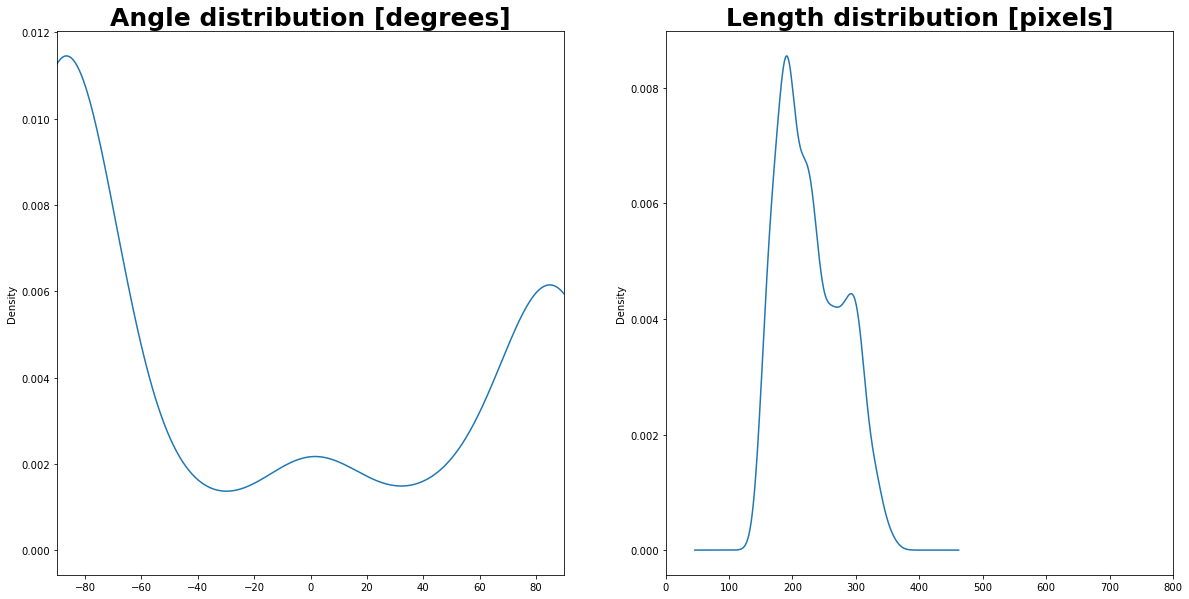

In [15]:
fig, ax = plt.subplots(ncols=2, nrows = 1, squeeze=False, figsize = (20,10))
data["angle"].plot(kind = "density", ax = ax[0,0])
ax[0,0].set_xlim((-90,90))
ax[0,0].set_title("Angle distribution [degrees]", size = 25, weight = "bold")

data["length"].plot(kind = "density", ax = ax[0,1])
ax[0,1].set_xlim((0,800))
ax[0,1].set_title("Length distribution [pixels]", size = 25, weight = "bold")

In [261]:
print(data.shape)
print(data.drop_duplicates(subset = ["length", "angle"]).shape)

(2605, 5)
(2394, 5)


Text(0.5, 1.0, 'Length distribution [pixels]')

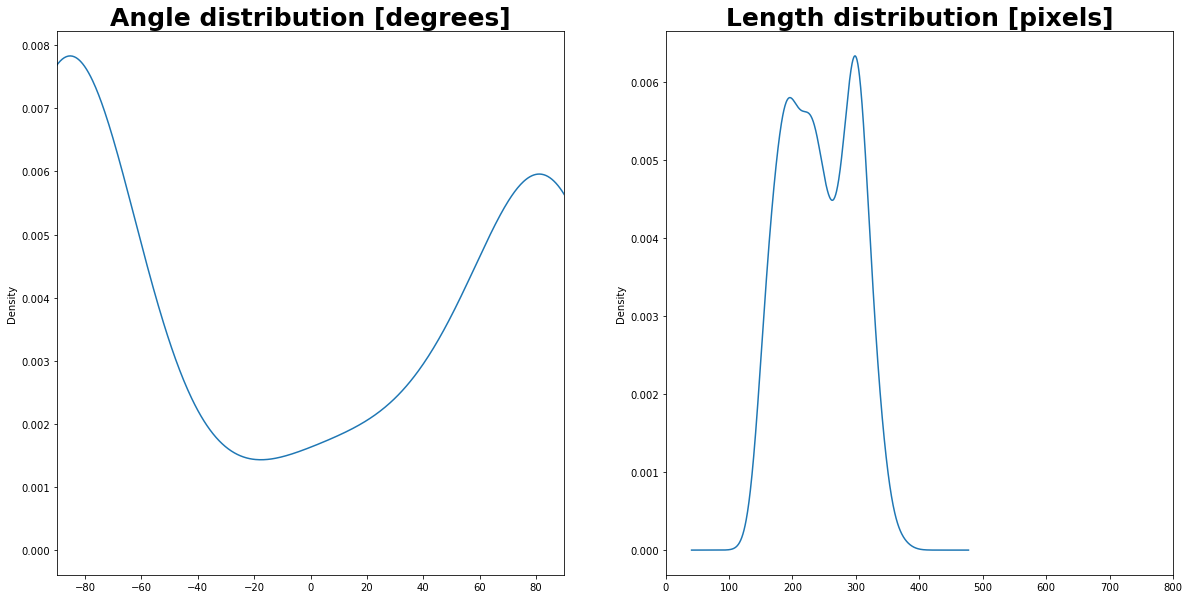

In [148]:
fig, ax = plt.subplots(ncols=2, nrows = 1, squeeze=False, figsize = (20,10))
data["angle"].plot(kind = "density", ax = ax[0,0])
ax[0,0].set_xlim((-90,90))
ax[0,0].set_title("Angle distribution [degrees]", size = 25, weight = "bold")

data["length"].plot(kind = "density", ax = ax[0,1])
ax[0,1].set_xlim((0,800))
ax[0,1].set_title("Length distribution [pixels]", size = 25, weight = "bold")

## Matching extracted lines to an image

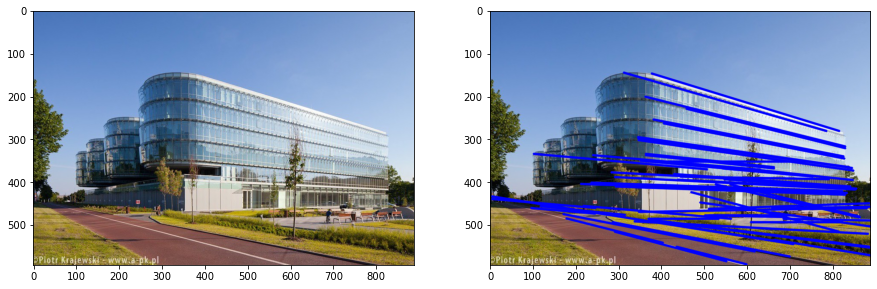

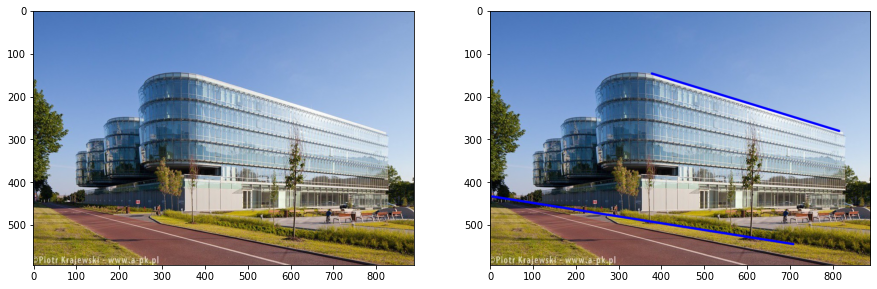

In [482]:
# Loading example image 


img = plt.imread("frames/contemporary/IMG_2864.jpeg") # downsizing each dimension to less than <1500 pixels is recommended 
img = plt.imread("frames/contemporary/ams.jpg")
img = plt.imread("frames/contemporary/gdy.jpg")
#img = plt.imread("frames/contemporary/bike.jpeg")
obj = matchingObjects(img = img,  scale = 1, margin = 0)

params_high_res_hough_prob = {"threshold": 200, "minLineLength":150, "maxLineGap":25} # use in case large images (more than 1000 pixels in width/heigh)

#threshold = 200 # The minimum number of intersections in hough space to "detect" a line. higher -> less lines
#minLineLength = 150 # The minimum number of points that can form a line. Lines with less than this number of points are disregarded. higher -> less lines
#maxLineGap = 25 # The maximum gap between two points to be considered in the same line. higher -> more lines

obj.hough_lines(probabilistic = True, radians = False, **params_high_res_hough_prob)

plot_lines(obj.img, obj.lines, probabilistic= True)
obj.rank_and_pick_lines(delta_angle = 3, max_lines =None) #filter out near-duplicate lines in the image
plot_lines(obj.img, obj.lines, probabilistic=True)

## Query the data frame for similiar lines

overlay the imgs from archives on new image, 
probabilistic approach on score
4-5 quries

In [483]:
def match_lines(data, obj,delta_angle = 3):
    """
    
    Matches the lines of the given MatchingObject against the lines detected and stored in data
    
    Parameters:
    ------------------------
    data: pandas DataFrame
        database of lines with columns: path, angle, line, length
    obj: object of class MatchingObject
        an object of class matchingObjects for which the lines from data are matchted
    delta_angle: int
        what is the furthest angle to yield a match? Note that the matches are first filtered on angle and only then on length
    TO-DO: length_prop - the proportion of length to be qualified as a match, e.g. length_prop=0.5 means that the matched length must be at least
    
    Returns: pandas DataFrame
        dataframe of lines with columns: path, scale, angle, line, length, line coords in the input image
        
    """
    matches = pd.DataFrame()
    for i in range(len(obj.lines)):
        close_angle_data = data.loc[(data["angle"] < obj.angle[i][0] + delta_angle)  & (data["angle"] > obj.angle[i][0] - delta_angle)] # we first sort by angle as it is more important to match than length
        match = close_angle_data.iloc[(close_angle_data['length']-obj.length[i][0]).abs().argsort()][:1] # given the angle data, find the closest match in length
        match["obj_line"] = [obj.lines[i]]
        match["obj_angle"] = obj.angle[i] # just to show how great the match is, can be deleted later
        match["obj_length"] = obj.length[i]
        matches = pd.concat([matches, match])
    matches.dropna(inplace = True) 
   #print(matches['line'])
    matches["line"] = matches["line"].apply(lambda x: x.flatten())
    matches["obj_line"] = matches["obj_line"].apply(lambda x: x.flatten())
    
    return matches

def score_the_line(matches, normalizing_stats, angle_weight = 1.0, length_weight = 1.0, num_lines = None):
    """
    Scores the lines striking a balance between angle (vertical lines preferred) and length (long lines preferred).
    The scoring method is based on a composite score of (normalized) angle and length, with user-specified weight for each. The normalization of each
    is done by subtracting the mean and dividing by the std.
    
    Parameters:
    -----------------------
    matches: pandas DataFrame
        contains information about the matched lines as returned by match_lines
    normalizing_stats: list like
        a list-like object contating mean and standard deviation of the absolute values of angle and length respectively (list of length 4)
    angle_weight: float
        weight of the angle in the score calculation
    length_weight: float
        weight of the length in the score calculation
    data: pandas DataFrame
        database of lines from the archive with columns: path, angle, line, length. Used to calculate the statistics if not supplied in normalizing_stats
    num_lines: int
        how many lines to return. Takes num_lines with the highest score
    
        
    Returns:
    ----------------------
        dataframe of lines with columns: path, scale, angle, line, length, line coords in the input image, score
    """
    matches_normalized = matches.copy()
    angle_mean, angle_std, length_mean, length_std = normalizing_stats

    matches_normalized = matches.copy()

    matches_normalized["angle_normalized"] = (abs(matches_normalized["angle"]) - angle_mean)/angle_std
    matches_normalized["length_normalized"] = (matches_normalized["length"] - length_mean)/length_std
    matches_normalized["score"] = angle_weight*matches_normalized["angle_normalized"] + length_weight*matches_normalized["length_normalized"]
    
    if num_lines == None:
        best_matches = matches_normalized.sort_values(by = "score", ascending=False)
    else:
        best_matches = matches_normalized.sort_values(by = "score", ascending=False)[:num_lines]
    return best_matches
    
def sample_line(matches, num_lines=1, factor = 2):
    """
    Samples num_line lines from 'matches' using random sampling where each consecutive row is 'factor'
    times less likely to be selected.
    
    Parameters:
    -------------------------------
    matches: pandas DataFrame
        dataframe with lines ordered by score
    num_lines: int
        how many lines to return. Takes num_lines with the highest score
    factor: float
        defines how the odds of each consecutive rows change
    
    Returns:
    ----------------------------------------------
    
    matches_new.sample(...): padnas data frame
        Samples of matches
    
    """
    matches_new = matches.copy()
    start_val = 1 # does not reallt matter as numbers will be 
    probs =[start_val]
    for i in range(matches.shape[0]-1):
        probs.append(probs[i]/factor)
    
    probs = np.array(probs)
    probs = probs/np.sum(probs)
    matches_new['probs'] = probs
    
    return matches_new.sample(n = num_lines, replace = False, weights = 'probs', axis = 0)


In [484]:
matches = match_lines(data, obj)
normalizing_stats = [np.mean(abs(data["angle"])), np.std(abs(data["angle"])), np.mean(data["length"]), np.std(data["length"])]
matches = score_the_line(matches, normalizing_stats, num_lines = None)
matches

path  scale  angle                line  \
937  frames/AV0539/keyframe_6153.0.jpg    0.5  18.88  [5, 146, 236, 225]   
681  frames/AV0539/keyframe_4333.0.jpg    0.5  10.13  [0, 239, 235, 281]   

     length              obj_line  obj_angle  obj_length  angle_normalized  \
937  244.14  [376, 147, 814, 281]  17.010762   458.03930         -2.111960   
681  238.72    [4, 433, 707, 544]   8.972627   711.70921         -2.445944   

     length_normalized     score  
937           0.320969 -1.790991  
681           0.211791 -2.234153

In [485]:
sample_line(matches)

path  scale  angle                line  \
681  frames/AV0539/keyframe_4333.0.jpg    0.5  10.13  [0, 239, 235, 281]   

     length            obj_line  obj_angle  obj_length  angle_normalized  \
681  238.72  [4, 433, 707, 544]   8.972627   711.70921         -2.445944   

     length_normalized     score     probs  
681           0.211791 -2.234153  0.333333

In [491]:
def get_the_line_rect(line_coords, img, margin_x = 0, margin_y =0):
    """ 
    Returns the rectangluar crop with diganol being the line with specified 'line_coords' optionally modified by a margin.
    
    Parameters:
    ---------------------------------------
    line_coords: list
        Has formate [x_start,y_start, x_end,y_end] 
    img: np.array
        an imgae
    margin_x: int
        How should the line be modified in x direction
    margin_y: int 
        How should the line be modified in x direction
        
    Returns: 
    ---------------------------------------
    matched_rect: np.array
        the cropped rectangle
    final_coords: list
        coordinates in the input image taking into account the margin and img_size
    
    """
    x_s,y_s,x_e,y_e = line_coords # get the coordinates of the line
    height_match, width_match, _ = img.shape
    x_s, y_s, x_e, y_e = max(min(x_s-margin_x, x_e-margin_x), 0), max(min(y_s-margin_y,y_e-margin_y),0), min(max(x_s+margin_x,x_e+margin_x), width_match), min(max(y_s+margin_y, y_e+margin_y), height_match)
   
    #matched_rect = img[max(min(y_s-margin_y,y_e-margin_y),0):min(max(y_s+margin_y, y_e+margin_y), height_match),
     #                                max(min(x_s-margin_x, x_e-margin_x), 0):min(max(x_s+margin_x,x_e+margin_x), width_match)]
    matched_rect = img[y_s:y_e, x_s:x_e]
    final_coords = [x_s, y_s, x_e, y_e]
    return matched_rect, final_coords
  
def overlay_on_img(img, matches, non_zero_objects_dic, margin_x = 0, margin_y= 0, adaptive_margin = True):
    """
    Takes the img and overlays the match(es) from 'matches' on it.
    
    Parameters:
    ---------------------------------------
    img: np.array
        an imgae
    matches: pandas DataFrame
    
    margin_x: int
        How should the line be modified in x direction
    margin_y: int 
        How should the line be modified in x direction
    adaptive_margin: bool
        Specifies if the automatic margin should be performed. 
        Automatic margin adds the margin based on trainge weight function. The added margin is 0 at 45 degrees and symmetric around 45 degrees.
        
        
    Returns: 
    ---------------------------------------
    matched_rect: np.array
        the cropped rectangle
    
    """
    new_img = img.copy()
    
    if adaptive_margin == True:
        weights = np.concatenate( (np.linspace(start = 20, stop = 0, num = 45), np.linspace(start = 0, stop = 20, num = 45) )) # maximally 15 pixels will be added
        weights_dic = {}
        for angle, weight in enumerate(weights):
            weights_dic[angle] = round(weight)
        
    for row_num in range(matches.shape[0]):
        row = matches.iloc[row_num] # 
        #print(row['path'][0], type(row['path']))
        the_match_obj = non_zero_objects_dic[row["path"]] # fetch the object from dic
        
        """
        x_s,y_s,x_e,y_e = row.loc['line'] # get the coordinates of the line
        width_match, height_match, _ = the_match_obj.img.shape
        matched_rect = the_match_obj.img[min(y_s-margin_y,y_e-margin_y, 0):max(y_s+margin_y, y_e+margin_y, height_match),
                                         min(x_s-margin_x, x_e-margin_x, 0):max(x_s+margin_x,x_e+margin, width_match)]"""
        
        if adaptive_margin:
            angle = round(abs(row["angle"]))
            #heigh_match, width_match, _ = the_match_obj.img
            if angle < 45: # increase the margin in y direction
                margin_y = weights_dic[angle]
            else: 
                margin_x = weights_dic[angle]
            print(angle, margin_x, margin_y)
            
            
        matched_rect, _ = get_the_line_rect(line_coords = row['line'], img = the_match_obj.img, margin_x=margin_x, margin_y = margin_y) # get the part to paste
        
        input_img_rect, input_coords = get_the_line_rect(line_coords = row['obj_line'], img = img, margin_x=margin_x, margin_y = margin_y)
        height_input, width_input,  _ = input_img_rect.shape
        
        matched_rect = cv2.resize(matched_rect, (width_input, height_input))
        
        new_img[input_coords[1]:input_coords[3], input_coords[0]:input_coords[2]] = matched_rect
    return new_img
        
    

19 0 11


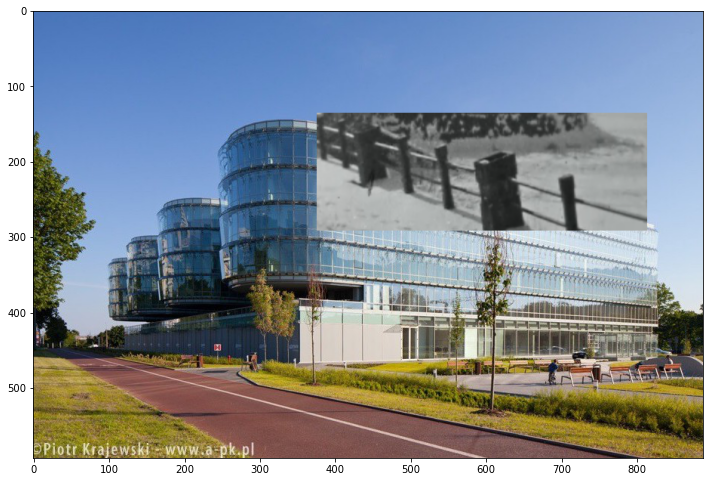

In [496]:
plt.figure(figsize = (12,12))
plt.imshow(overlay_on_img(img, sample_line(matches), non_zero_objects_dic, adaptive_margin = True))

In [426]:
matches.loc[[433]]

path  scale  angle                line  \
433  frames/AV0843/keyframe_6902.0.jpg    0.5 -39.13  [12, 248, 205, 91]   

     length              obj_line  obj_angle  obj_length  angle_normalized  \
433  248.79  [428, 894, 679, 684] -39.917652  327.262891         -1.339026   

     length_normalized     score  
433           0.414637 -0.924389

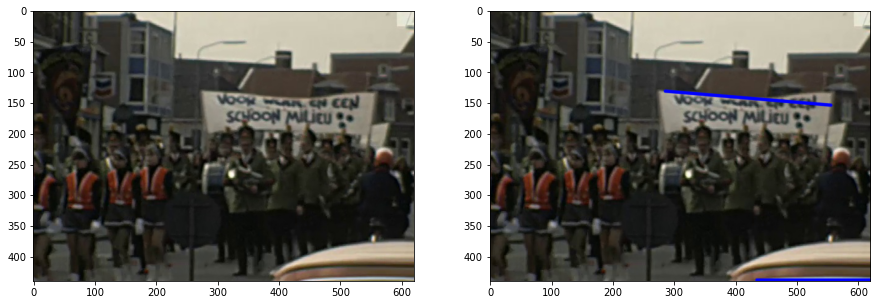

In [23]:
obj1 = matchingObjects(data.loc[num]["path"])
obj1.hough_lines()
obj1.rank_and_pick_lines(delta_angle = 3, max_lines = 7)
plot_lines(obj1.img, obj1.lines)


## Tasks:
- biasing towards vertical lines
- lines different scales: the whole procedure above can be performed for images on arbitrary scales
- params for modern images: params_high_res_hough_prob = {"threshold": 200, "minLineLength":150, "maxLineGap":25} # use in case large images (more than ~800 pixels in width/height)
- added gaussian blur prior to probabilistic hough transform to filter out weak detections
- Lines with angle -90 and +90: easy to do (duplicate rows with -90 and 90 with a flipped sign, resulting in a sligtly larger DF) but given a lot of frames redundant: we will find a good match anyway

## Thoughts
Lines with angle -90 and +90: easy to do (duplicate the rows with  need to replicate -90 and 

In [42]:
np.expand_dims(data.loc[66]["line"], axis = 0).shape

(1, 1, 4)

In [19]:
plt.imshow(img_with_matches[org_line[1]:org_line[1] + org_line[3], org_line[0]: org_line[0] + org_line[2] ])

NameError: name 'img_with_matches' is not defined

In [20]:
img_with_matches = np.copy(obj.img)
buffer = 2
for num_matches in range(matches.shape[0]):
    
    match = matches.iloc[[num_matches]]
    take_from = plt.imread(match.index[0]) # load the image from which we take the line
    width, height, _ = take_from.shape
    
    org_line = match['obj_line'][0]
    new_line = match["line"][0]
    to_paste = cv2.resize(take_from[max(new_line[1] - buffer, 0): min(new_line[3] + buffer, height), max(new_line[0] - buffer, 0): min(new_line[2] + buffer, width)],
                         ( org_line[2]-org_line[0], org_line[3] - org_line[1]))
    
    #print(org_line)
    #print(to_paste.shape)
    #print(img_with_matches[org_line[1]: org_line[3], org_line[0]: org_line[2] ].shape)
    
    img_with_matches[org_line[1]: org_line[3], org_line[0]: org_line[2]] = to_paste
        

In [21]:
match

angle                 line      length  \
path                                                                            
frames/AV0539/keyframe_7253.0.jpg  14.005669  [166, 18, 607, 128]  454.511826   

                                               obj_line  
path                                                     
frames/AV0539/keyframe_7253.0.jpg  [286, 777, 805, 916]

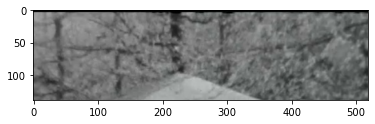

In [75]:
plt.imshow(to_paste)

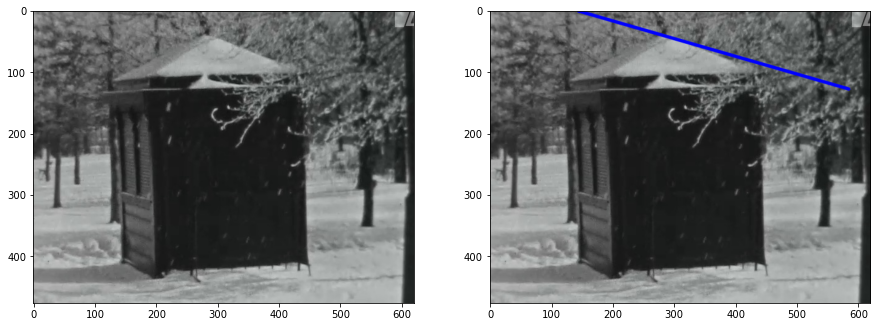

In [92]:
inv = matchingObjects(path = "frames/AV0539/keyframe_7264.0.jpg" )
inv.hough_lines()
inv.rank_and_pick_lines(max_lines = 3, delta_angle = 3)
plot_lines(inv.img, [inv.lines[-1]])

In [88]:
inv.lines

array([[[169, 131, 605, 116]],

       [[195,   3, 607, 169]],

       [[143,   1, 584, 128]]], dtype=int32)

In [90]:
obj.angle

array([[61.96210361],
       [88.05485324],
       [14.99323972]])

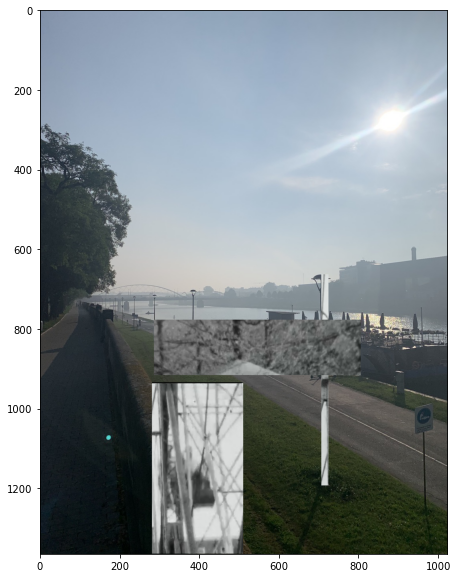

In [22]:
plt.figure(figsize = (10,10))
plt.imshow(img_with_matches)

In [60]:
img_with_matches[934:1364, 281:510].shape

(430, 229, 3)

In [61]:
org_line[1]

934

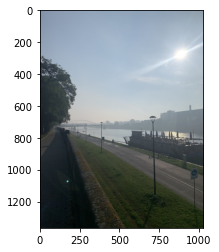

In [520]:
plt.imshow(img_with_matches)

In [ ]:
def plot_matches(matches, obj):
    

In [429]:
data.loc[data["angle"]> & data["len"]]

SyntaxError: invalid syntax (<ipython-input-429-0643b205cb28>, line 1)

In [444]:
delta_angle = 5 # what is the furthest angle to yield a match?
close_angle_data = data.loc[(data["angle"] < obj.angle[0][0] + delta_angle)  & (data["angle"] > obj.angle[0][0] - delta_angle)] # we first sort by angle as it is more important than length
match = close_angle_data.iloc[(close_angle_data['length']-obj.length[0][0]).abs().argsort()][:1] # given the angle data, find the closest match in length

In [485]:
k = pd.concat([pd.DataFrame(), match])
k["arka"] = 2

In [486]:
k

angle                  line  \
path                                                                 
frames/AV0539/keyframe_7120.0.jpg  64.958414  [[321, 9, 499, 390]]   

                                       length  arka  
path                                                 
frames/AV0539/keyframe_7120.0.jpg  420.529428     2

In [454]:
match.index[0]

'frames/AV0539/keyframe_7120.0.jpg'

In [52]:
match_img = plt.imread(match.index[0])
buffer = 3
match_img[9:390, 321:390].shape

(381, 69, 3)

In [441]:
obj.angle[0][0]

61.9621036054125

In [442]:
obj.length

array([[487.17655937],
       [530.30557229],
       [537.29135485]])

In [443]:
data.iloc[(data['angle']-obj.angle[0][0]).abs().argsort()][:1]

angle                 line      length
path                                                                          
frames/AV0539/keyframe_12514.0.jpg  61.949224  [[61, 0, 207, 274]]  310.470611

In [ ]:
# pick longest lines, diveristy parameter for the angle

In [109]:
get_angle(hough_lines)

array([[ 0.46760016],
       [ 1.53660443],
       [ 0.26320946],
       [ 0.78539816],
       [ 0.03569911],
       [ 0.45463884],
       [ 0.26250675],
       [ 1.04699728],
       [ 0.83752481],
       [ 0.47153699],
       [ 0.46876265],
       [ 1.32974306],
       [ 1.04542945],
       [ 0.19220829],
       [-0.01844809],
       [ 0.34956183],
       [ 1.32387403],
       [ 0.20934158],
       [ 1.14992417],
       [ 0.03729613],
       [ 0.85433109],
       [ 0.26082388],
       [ 1.15077182],
       [ 0.85480521],
       [ 1.13511345],
       [ 1.15043616],
       [ 0.18932192],
       [ 1.32679423],
       [ 1.3277959 ],
       [ 0.05180546],
       [ 0.12352889],
       [ 0.15541845],
       [ 0.15819996],
       [ 0.19043512],
       [ 0.47052035],
       [ 0.15482041],
       [ 0.05473978],
       [ 0.05233312],
       [ 0.08659958],
       [ 0.05180546],
       [ 0.19288431],
       [ 0.19260326],
       [ 0.1740036 ],
       [ 1.32974306],
       [ 1.14937712],
       [ 1

In [106]:
np.arctan2(hough_lines[:, :,3] - hough_lines[:, :,1], hough_lines[:, :,2] - hough_lines[:, :,0])# * 180/np.pi

array([[26.79151553],
       [88.04094839],
       [15.08079131],
       [45.        ],
       [ 2.04540849],
       [26.04888695],
       [15.04052877],
       [59.9885253 ],
       [47.98663699],
       [27.01707951],
       [26.85812166],
       [76.18866521],
       [59.89869543],
       [11.0127236 ],
       [-1.05699778],
       [20.02841753],
       [75.85239461],
       [11.9943892 ],
       [65.88580146],
       [ 2.13691085],
       [48.94956564],
       [14.94410727],
       [65.93436842],
       [48.97673098],
       [65.03721017],
       [65.91513663],
       [10.84734684],
       [76.01970942],
       [76.07710115],
       [ 2.96823403],
       [ 7.07768403],
       [ 8.90482099],
       [ 9.06418991],
       [10.91112838],
       [26.9588304 ],
       [ 8.87055586],
       [ 3.13635837],
       [ 2.99846714],
       [ 4.96179071],
       [ 2.96823403],
       [11.05145703],
       [11.03535416],
       [ 9.96967195],
       [76.18866521],
       [65.85445804],
       [65